In [621]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as optimize
from scipy.odr import *
from uncertainties import ufloat, umath
import statistics
%matplotlib inline

# Period vs Angle

In [622]:
period3 = np.array([6.287 , 6.087, 6.087, 6.236, 5.820, 5.636 , 5.403, 5.383, 5.520, 5.785, 5.592, 5.653, 5.720, 5.870, 6.037  ,6.187 , 6.320, 6.705])
lenght_of_string = ufloat(0.980, 0.001) # m 

In [623]:
# Data for plotting

## We generate a sequence of angles from -90 to 90 Deg, in interals of 10 Deg, excluding 0, and we convert these values to radians
angleDegrees = np.arange(-90, 100, 10)

for i in range(len(angleDegrees) - 1):
    if angleDegrees[i] == 0:
        angleDegrees = np.delete(angleDegrees, i)
        
angleRadians = np.radians(angleDegrees)

# Period 3 is the time needed to complete 3 oscilations, the period of one oscilation will be the period divided by 3.
period = period3 / 3

In [624]:
# best fit:

# Power series function to fit the data to
def f(t, a, b, c):
    return a*t**2 + b*t + c

(a, b, c), pcov = optimize.curve_fit(f, angleRadians, period, sigma=[(0.05)] * len(period))

# compute the standard deviation error of the parameters
u_a, u_b, u_c = pcov[0,0]**(0.5), pcov[1,1]**(0.5), pcov[2,2]**(0.5)

low, high = min(angleRadians), max(angleRadians)   
xs = np.arange(low, high, (high-low)/1000) 
curve = f(xs, a, b, c) 

In [625]:
## We run a Orthogonal distance regression so as to take into account both x errors and y errors in the regression.

x_err = 3 / 60
y_err = sigma=[(0.05)] * len(period)

def f(p, t):
    a, b, c = p
    return a*t**2 + b*t + c

model = Model(f)
data = RealData(angleRadians, period, sx=x_err, sy=y_err)
myodr = ODR(data, model, beta0=[0.1, 0.1, 0.1])
out = myodr.run()

low, high = min(angleRadians), max(angleRadians)   
xs = np.arange(low, high, (high-low)/1000) 
curve = f(out.beta, xs) 

In [626]:
a = ufloat(out.beta[0], out.sd_beta[0])
b = ufloat(out.beta[1], out.sd_beta[1])
c = ufloat(out.beta[2], out.sd_beta[2])
print("Fit parameters: \n", f"a: {a} \n", f"b: {b} \n", f"c: {c} \n")

print("In our equation: \n", f"T0: {c} \n", f"B: {b/c} \n", f"C: {a/c}\n")

print(f"smalles angle so period can be assumed to be constant: {umath.sqrt((3/60)/a)}")

Fit parameters: 
 a: 0.133+/-0.014 
 b: 0.023+/-0.011 
 c: 1.841+/-0.017 

In our equation: 
 T0: 1.841+/-0.017 
 B: 0.013+/-0.006 
 C: 0.072+/-0.008

smalles angle so period can be assumed to be constant: 0.614+/-0.032


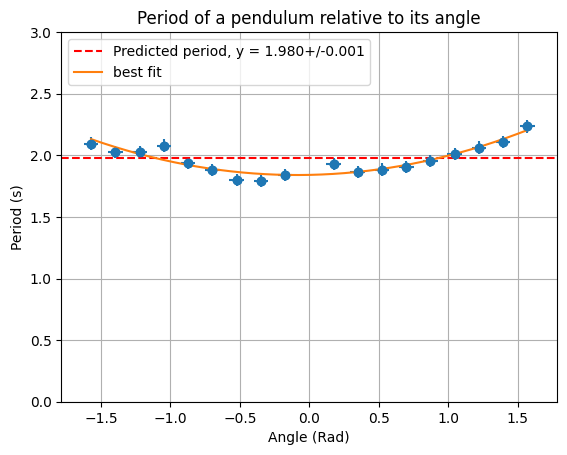

In [627]:
fig, ax = plt.subplots()

ax.scatter(angleRadians, period)

ax.set(xlabel='Angle (Rad)', ylabel='Period (s)',
       title='Period of a pendulum relative to its angle',
       ylim=(0,3))

ax.grid()

ax.errorbar(angleRadians, period, yerr=y_err, xerr=(3 * np.pi / 180), fmt="o")

fit = np.polyfit(angleRadians, period, deg=2)
predictedPeriod = 2 * umath.sqrt(lenght_of_string)

#Predicted period line
ax.axhline(y=predictedPeriod.n, color='r', linestyle='--', label="Predicted period, " + 'y = ' + '{:.1u}'.format(predictedPeriod))


ax.plot(xs, curve, label="best fit")


plt.legend(loc="upper left")
# save graph
plt.savefig('period_angle.png', dpi=700)

<Figure size 640x480 with 0 Axes>

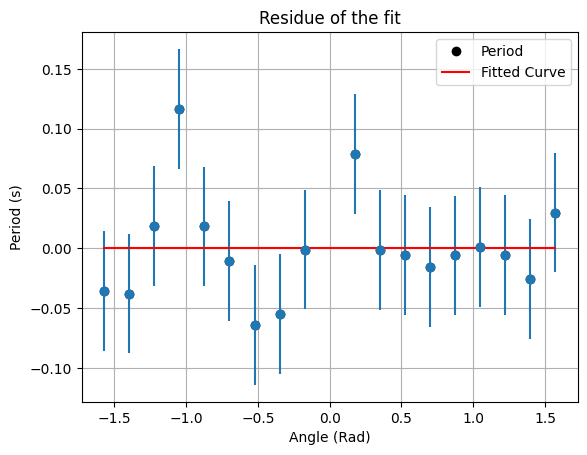

In [628]:
# residual
plt.clf()
fig, ax = plt.subplots()
ax.set(xlabel='Angle (Rad)', ylabel='Period (s)',
       title='Residue of the fit')
ax.grid()
ax.plot(angleRadians, period - f(out.beta, angleRadians), 'ko', label="Period")
ax.errorbar(angleRadians, period - f(out.beta, angleRadians), yerr=y_err, fmt="o")
ax.plot(angleRadians, [0] * angleRadians, 'r-', label="Fitted Curve")

ax.legend()

# save graph
plt.savefig('period_angle_residual.png', dpi=700)

In [629]:
average = ufloat(np.mean(period), statistics.stdev(period) / np.sqrt(len(period)))
print(f"average period for the experiment is {average}")
print(f"period predicted by theory is {2 * umath.sqrt(lenght_of_string)}")
      

average period for the experiment is 1.969+/-0.028
period predicted by theory is 1.9799+/-0.0010


In [630]:
# get r^2
residuals = period - f(out.beta, angleRadians)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((period-np.mean(period))**2)
r_squared = 1 - (ss_res / ss_tot)
print(f"R^2 is {r_squared}")

R^2 is 0.8671448081524961


In [631]:
# get R^2 compared to predicted period
residuals = period - predictedPeriod
ss_res = np.sum(residuals**2)
ss_tot = np.sum((period-np.mean(period))**2)
r_squared = 1 - (ss_res / ss_tot)
print(f"R^2 is {r_squared}")

R^2 is -0.0087+/-0.0016


uncertainties:
angle: 0.5 deg
time 0.2 s

27.6:
    

# maximum amplitude vs number of oscilations
(Pednulum length: 1.08m)

In [632]:
# oscilations = np.arange(1, 58)
# amplitude_deg = [62, 61, 56, 55, 52, 50, 50, 48, 46, 40, 36, 35, 34, 32, 31, 30, 30, 29, 29, 28, 28, 27, 27, 27, 26, 25, 25, 25, 25,  25, 24, 24, 23, 23, 23, 23, 23, 22, 22, 22, 22, 21, 21, 21, 20, 20, 20, 20, 19, 19, 19, 18, 18, 18, 17, 17, 16]
# amplitude_rad = np.radians(amplitude_deg)
# period = [2.00, 2.067, 2.013, 2.067, 2.164, 2.066, 2.034,  2.100, 2.166, 2.034, 1.998, 2.100, 2.033, 2.100, 2.000, 2.134, 2.100, 2.043, 2.056, 2.121, 2.091, 2.002, 2.054, 2.143, 2.034, 2.074, 2.142, 2.006, 2.044, 2.100, 2.079, 2.006, 2.004, 2.104, 2.112, 2.012, 2.104, 2.034, 2.065, 2.102, 2.031, 2.111, 2.018, 2.082, 2.034, 2.092, 2.034, 2.045, 2.120, 2.063, 2.043, 2.055, 2.046, 2.032, 2.072, 2.004, 2.124]
# time = [sum(period[:(i + 1)]) for i in range(len(period))]
# y_err =[(0.05)] * len(amplitude_rad)
# oscilation = range(len(amplitude_rad))

In [633]:
data=loadtxt("model/angle.txt", usecols=(0,1), skiprows=153, unpack=True)
data[1] = data[1] + np.pi /2

x = np.array(data[0][1000:-100])
y = np.array(data[1][1000:-100])

x_max = []
y_max = []
period = []

for i in range(len(x)):
    if i < len(x) - 2 and  y[i-2] < y[i] and y[i-1] < y[i] and y[i+1] < y[i] and y[i+2] < y[i] and (len(y_max) == 0 or y[i] - y_max[-1] < 1):
        if len(y_max) > 0:
            period = period + [x[i] - x_max[-1]]
        x_max = x_max + [x[i]]
        y_max = y_max + [y[i]]

In [634]:
def func(x, q):
    return np.radians(60) * np.exp(- x * np.pi / (q * np.mean(period)))

x = np.array(x_max)
y = y_max

y_err = [0.0556] * len(x)

popt, pcov = optimize.curve_fit(func, x, y, sigma=y_err, p0=[160])

<Figure size 640x480 with 0 Axes>

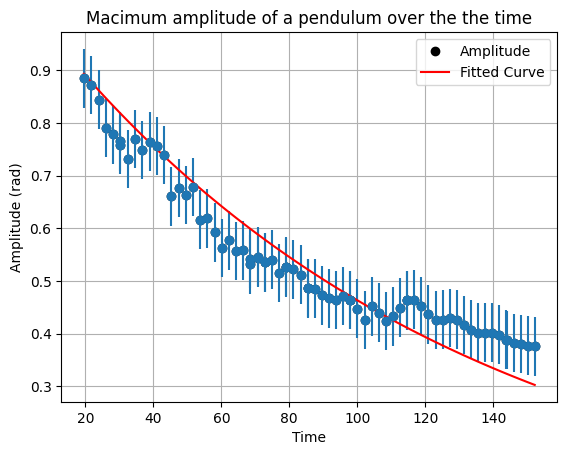

In [635]:
plt.clf()
fig, ax = plt.subplots()
ax.set(xlabel='Time', ylabel='Amplitude (rad)',
       title='Macimum amplitude of a pendulum over the the time')
ax.grid()
ax.plot(x, y, 'ko', label="Amplitude")
ax.errorbar(x, y, yerr=y_err, fmt="o")
ax.plot(x, func(x, *popt), 'r-', label="Fitted Curve")

ax.legend()

plt.savefig('amplitude_oscilations.png', dpi=700)

<Figure size 640x480 with 0 Axes>

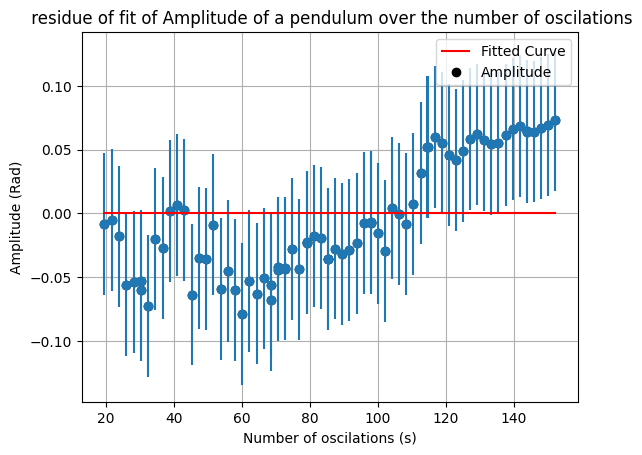

In [636]:
# residual
plt.clf()
fig, ax = plt.subplots()
ax.set(xlabel='Number of oscilations (s)', ylabel='Amplitude (Rad)',
       title=' residue of fit of Amplitude of a pendulum over the number of oscilations')
ax.grid()
ax.plot(x, [0] * x, 'r-', label="Fitted Curve", zorder=10)
ax.plot(x, y  - func(x, *popt), 'ko', label="Amplitude")
ax.errorbar(x, y - func(x, *popt), yerr=y_err, fmt="o")

ax.legend()

plt.savefig('amplitude_oscilations_residue.png', dpi=700)

In [637]:
print(f'Q factor is {ufloat(popt[0], np.sqrt(pcov[0,0]))}')

Q factor is 209.2+/-3.3


In [638]:
# get r^2
residuals = y - func(x, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
print(f"R^2 is {r_squared}")

R^2 is 0.8867205227726713


# Position vs time

In [639]:
from pylab import loadtxt

In [640]:
data=loadtxt("model/angle.txt", usecols=(0,1), skiprows=153, unpack=True)
data[1] = data[1]
x = np.array(data[0][2000:])
y = np.array(data[1][2000:])
y_err = [0.0556] * len(x)

In [641]:
def damped_sinusoid(t, q, T, phi, disp):
    return np.radians(60) * np.exp(- t * np.pi / (q * T))*np.cos(2*np.pi*t/T+phi) + disp

init_guess = (220, 1.84, 0.0, np.pi / 2)

popt, pcov = optimize.curve_fit(damped_sinusoid, x, y, sigma=y_err,
p0=init_guess)

<Figure size 640x480 with 0 Axes>

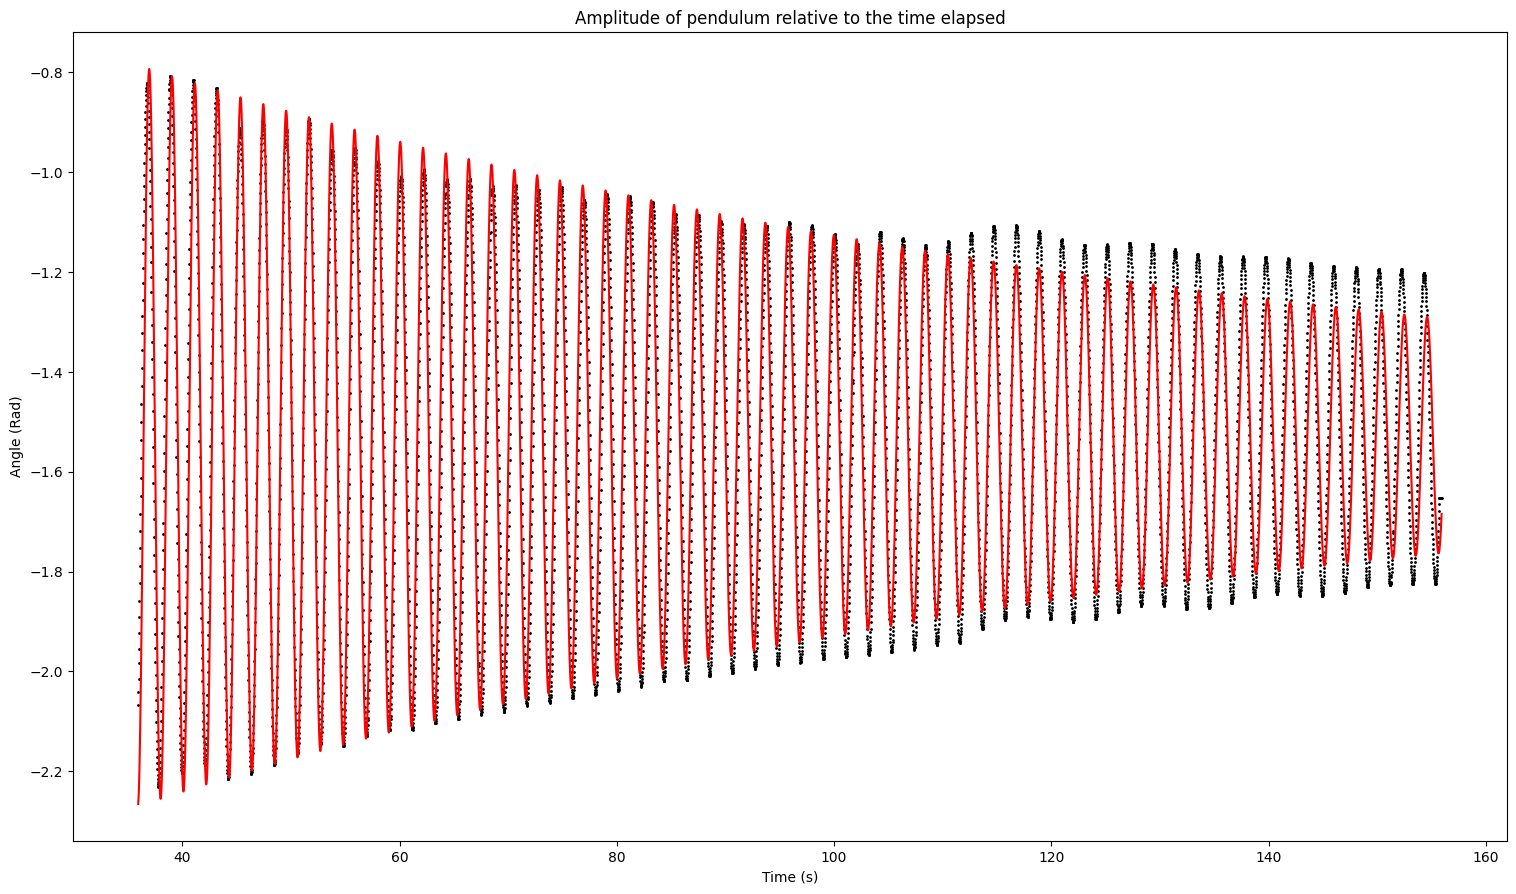

In [642]:
plt.clf()
fig, ax = plt.subplots()
ax.set(xlabel='Time (s)', ylabel='Angle (Rad)',
       title='Amplitude of pendulum relative to the time elapsed')
fig.set_size_inches(18.5, 10.5)
ax.plot(x, y, 'ko', label="Amplitude (Rad)", markersize=1)
ax.plot(x, damped_sinusoid(x, *popt) , 'r-', label="Fitted Curve")
plt.savefig('amplitude_time.png', dpi=700)

<Figure size 640x480 with 0 Axes>

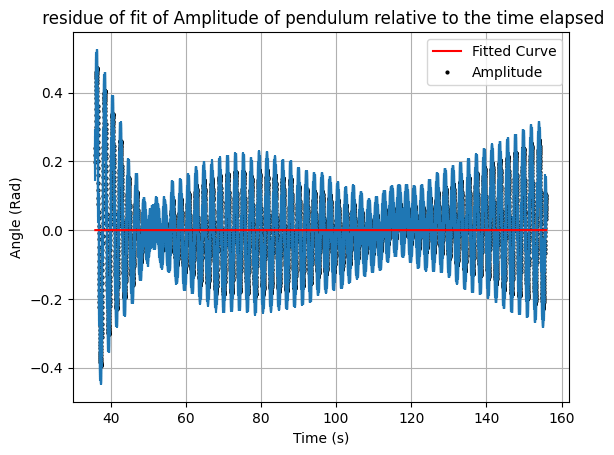

In [643]:
# residual
plt.clf()
fig, ax = plt.subplots()
ax.set(xlabel='Time (s)', ylabel='Angle (Rad)',
       title=' residue of fit of Amplitude of pendulum relative to the time elapsed')
ax.grid()
ax.plot(x, [0] * x, 'r-', label="Fitted Curve", zorder=10)
ax.plot(x, y  - damped_sinusoid(x, *popt), 'ko', label="Amplitude", markersize=2)
ax.errorbar(x, y - damped_sinusoid(x, *popt), yerr=y_err, fmt="o", markersize=1)

ax.legend()

plt.savefig('amplitude_time_residue.png', dpi=700)

In [644]:
Q = ufloat(popt[0], np.sqrt(pcov[0,0]))
print(f'Q factor is {Q}')

Q factor is 156.1+/-0.8


In [645]:
# get r^2
residuals = y - damped_sinusoid(x, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
print(f"R^2 is {r_squared}")

R^2 is 0.8875592570955508
